<a href="https://colab.research.google.com/github/alecishuman/Handwritten-Math-Symbols/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
!pip install kaggle
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d guru001/hasyv2

 98% 140M/143M [00:01<00:00, 124MB/s]
100% 143M/143M [00:01<00:00, 120MB/s]


In [ ]:
zip_ref = zipfile.ZipFile('/content/hasyv2.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
df = pd.read_csv("/content/hasy-data-labels.csv")
df.drop(columns=["user_id"])

,path,symbol_id,latex
0,hasy-data/v2-00000.png,31,A
1,hasy-data/v2-00001.png,31,A
2,hasy-data/v2-00002.png,31,A
3,hasy-data/v2-00003.png,31,A
4,hasy-data/v2-00004.png,31,A
...,...,...,...
168228,hasy-data/v2-168228.png,1400,\guillemotleft
168229,hasy-data/v2-168229.png,1400,\guillemotleft
168230,hasy-data/v2-168230.png,1400,\guillemotleft
168231,hasy-data/v2-168231.png,1400,\guillemotleft


In [ ]:
df[df['latex'] == '\sum']

,path,symbol_id,latex,user_id
981,hasy-data/v2-00981.png,88,\sum,50
982,hasy-data/v2-00982.png,88,\sum,44
983,hasy-data/v2-00983.png,88,\sum,10
984,hasy-data/v2-00984.png,88,\sum,3294
985,hasy-data/v2-00985.png,88,\sum,6672
...,...,...,...,...
28616,hasy-data/v2-28616.png,88,\sum,100868
28617,hasy-data/v2-28617.png,88,\sum,100912
28618,hasy-data/v2-28618.png,88,\sum,100912
28619,hasy-data/v2-28619.png,88,\sum,100912


In [ ]:
x = []
y = []
path = '/content/'
index = 0
for path2 in df['path']:
  if (df['symbol_id'][index] == 31):
    y.append(0)
  elif (df['symbol_id'][index] == df['symbol_id'][index-1]):
    y.append(y[len(y)-1])
  else:
    y.append(y[len(y)-1]+1)
  img = Image.open(path + path2)
  img = img.resize((32,32))
  img = np.asarray(img)
  if len(img.shape) == 3:
    img = np.mean(img, axis=2)
  x.append(img)
  index += 1

In [ ]:
X=np.array(x)
y=np.array(y)
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=4)
X_train = X_train.reshape(-1, 32, 32, 1)
X_val = X_val.reshape(-1, 32, 32, 1)
X_train_scaled = X_train/255
X_val_scaled = X_val/255

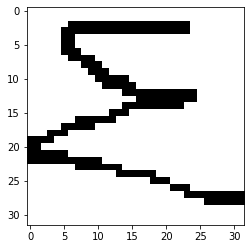

In [ ]:
plt.imshow(X[1001], cmap="gray")

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(1,1),input_shape=(32, 32, 1), activation='sigmoid',padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 1), activation='sigmoid',padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(369, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(1,1),input_shape=(32, 32, 1), activation='relu',padding='same'))
model2.add(MaxPool2D(pool_size=(1, 1)))
model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='sigmoid',padding='same'))
model2.add(MaxPool2D(pool_size=(1, 1)))
model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='sigmoid',padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='sigmoid',padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(369, activation='softmax'))
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
y_sym_val = to_categorical(y_val,369)
y_sym_train = to_categorical(y_train,369)
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
model.fit(X_train,y_sym_train,epochs=10,validation_data=(X_val,y_sym_val),callbacks=[early_stop])

Epoch 1/10
4206/4206 [==============================] - 206s 49ms/step - loss: 1.8878 - accuracy: 0.5795 - val_loss: 1.1278 - val_accuracy: 0.7219
Epoch 2/10
4206/4206 [==============================] - 200s 48ms/step - loss: 0.9345 - accuracy: 0.7531 - val_loss: 0.9518 - val_accuracy: 0.7462
Epoch 3/10
4205/4206 [============================>.] - ETA: 0s - loss: 0.7546 - accuracy: 0.7912

KeyboardInterrupt: ignored

In [ ]:
print(model.evaluate(X_val,y_sym_val,verbose=0))

In [ ]:
model.summary()

In [ ]:
losses = pd.DataFrame(model3.history.history)
losses[['accuracy','val_accuracy']].plot()

In [ ]:
losses[['loss','val_loss']].plot()
plt.ylim(0,1)